In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torchvision import datasets
from torch.utils.data import DataLoader

from torchvision import models
from torchvision.transforms import Compose, Resize, CenterCrop, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip, Normalize, ToTensor

from fl_g13.config import RAW_DATA_DIR
from fl_g13.modeling import train, eval, save, load, backup, load_loss_and_accuracies, save_loss_and_accuracy
from fl_g13.dataset import train_test_split

from fl_g13.architectures import BaseDino
from fl_g13.editing import SparseSGDM

2025-05-03 12:31:35.914 | INFO     | fl_g13.config:<module>:11 - PROJ_ROOT path is: /home/massimiliano/Projects/fl-g13


In [3]:
# Define preprocessing pipeline
train_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    RandomCrop(224), # But Dino works on 224x224
    RandomHorizontalFlip(),
    ToTensor(),
    #Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]), # CIFRAR100 Train stats
    Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # Use ImageNet stats
])

eval_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    CenterCrop(224), # But Dino works on 224x224
    ToTensor(),
    #Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]), # CIFRAR100 Train stats
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Use ImageNet stats
])

cifar100_train = datasets.CIFAR100(root=RAW_DATA_DIR, train=True, download=True, transform=train_transform)
cifar100_test = datasets.CIFAR100(root=RAW_DATA_DIR, train=False, download=True, transform=eval_transform)

# Always specify a random state, otherwise the split will be different each time 
# If you have intention to load a model mid-training, you may have part of the validation set as already seen in the previous training
train_dataset, val_dataset = train_test_split(cifar100_train, 0.8, random_state=42)
test_dataset = cifar100_test

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000


In [4]:
# Move to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Settings
CHECKPOINT_DIR = "/home/massimiliano/Projects/fl-g13/checkpoints"
name="arcanine"
start_epoch=1
num_epochs=80
save_every=5
backup_every=20

# Model Hyper-parameters
head_layers=3
head_hidden_size=512
dropout_rate=0.0
unfreeze_blocks=1

# Training Hyper-parameters
batch_size=128
lr=1e-3
momentum=0.9
weight_decay=1e-5
T_max=8
eta_min=1e-5

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model
model = BaseDino(
    head_layers=head_layers, 
    head_hidden_size=head_hidden_size, 
    dropout_rate=dropout_rate, 
    unfreeze_blocks=unfreeze_blocks
    )
model.to(device)

# Optimizer, scheduler, and loss function
mask = [torch.ones_like(p, device=p.device) for p in model.parameters()] # Must be done AFTER the model is moved to CUDA
optimizer = SparseSGDM(
    model.parameters(),
    mask=mask,
    lr=lr,
    momentum=momentum,
    weight_decay=weight_decay
    )
scheduler = CosineAnnealingLR(
    optimizer=optimizer, 
    T_max=T_max, 
    eta_min=eta_min
    )
criterion = CrossEntropyLoss()

all_training_losses=[]       # Pre-allocated list for training losses
all_validation_losses=[]       # Pre-allocated list for validation losses
all_training_accuracies=[]    # Pre-allocated list for training accuracies
all_validation_accuracies=[]    # Pre-allocated list for validation accuracies

# ---- RESUME ----

# # Model loading (uncomment to properly overwrite)
# loading_epoch = 80
# model, start_epoch = load(
#     f"{CHECKPOINT_DIR}/BaseDino/{name}_BaseDino_epoch_{loading_epoch}.pth",
#     model_class=BaseDino,
#     device=device,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     verbose=True
# )
# model.to(device)
# loaded_metrics = load_loss_and_accuracies(path=f"{CHECKPOINT_DIR}/BaseDino/{name}_BaseDino_epoch_{loading_epoch}.loss_acc.json")

# # Preallocated lists: if the training interrupts, it will still save their values (uncomment to properly load and overwrite)
# all_training_losses=loaded_metrics["train_loss"]       # Pre-allocated list for training losses
# all_validation_losses=loaded_metrics["val_loss"]       # Pre-allocated list for validation losses
# all_training_accuracies=loaded_metrics["train_acc"]    # Pre-allocated list for training accuracies
# all_validation_accuracies=loaded_metrics["val_acc"]    # Pre-allocated list for validation accuracies

# -----------------

print(f"\nModel: {model}")

Using device: cuda


Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main



Model: BaseDino(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm):

In [5]:
# Get one batch of data from the test dataloader
data_iter = iter(test_dataloader)
images, labels = next(data_iter)

# Move the data to the same device as the model
images = images.to(device)

# Perform prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Print the first prediction and its corresponding label
print(f"Predicted class: {predicted[0].item()}, True class: {labels[0].item()}")
print(f"Outputs shape: {outputs.shape}")

Predicted class: 25, True class: 49
Outputs shape: torch.Size([128, 100])


In [6]:
try:
    _, _, _, _ = train(
        checkpoint_dir=CHECKPOINT_DIR,
        name=name,
        start_epoch=start_epoch,
        num_epochs=num_epochs,
        save_every=save_every,
        backup_every=backup_every,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        verbose=1,
        all_training_losses=all_training_losses,
        all_validation_losses=all_validation_losses,
        all_training_accuracies=all_training_accuracies,
        all_validation_accuracies=all_validation_accuracies,
    )

except KeyboardInterrupt:
    print("Training interrupted manually.")

except Exception as e:
    print(f"Training stopped due to error: {e}")

Prefix/name for the model was provided: arcanine



Training progress: 100%|██████████| 313/313 [01:42<00:00,  3.05batch/s]


🚀 Epoch 1/80 (1.25%) Completed
	📊 Training Loss: 2.1110
	✅ Training Accuracy: 46.71%
	⏳ Elapsed Time: 102.67s | ETA: 8111.30s
	🕒 Completed At: 12:33


Eval progress: 100%|██████████| 79/79 [00:22<00:00,  3.48batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.3397
	🎯 Validation Accuracy: 62.18%



Training progress: 100%|██████████| 313/313 [01:42<00:00,  3.05batch/s]


🚀 Epoch 2/80 (2.50%) Completed
	📊 Training Loss: 1.0653
	✅ Training Accuracy: 68.69%
	⏳ Elapsed Time: 102.73s | ETA: 8013.29s
	🕒 Completed At: 12:35


Eval progress: 100%|██████████| 79/79 [00:22<00:00,  3.45batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0873
	🎯 Validation Accuracy: 69.04%



Training progress: 100%|██████████| 313/313 [01:52<00:00,  2.78batch/s]


🚀 Epoch 3/80 (3.75%) Completed
	📊 Training Loss: 0.8006
	✅ Training Accuracy: 75.78%
	⏳ Elapsed Time: 112.59s | ETA: 8669.06s
	🕒 Completed At: 12:37


Eval progress: 100%|██████████| 79/79 [00:26<00:00,  2.94batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0087
	🎯 Validation Accuracy: 71.16%



Training progress: 100%|██████████| 313/313 [01:51<00:00,  2.81batch/s]


🚀 Epoch 4/80 (5.00%) Completed
	📊 Training Loss: 0.6277
	✅ Training Accuracy: 80.75%
	⏳ Elapsed Time: 111.55s | ETA: 8477.45s
	🕒 Completed At: 12:40


Eval progress: 100%|██████████| 79/79 [00:22<00:00,  3.54batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8983
	🎯 Validation Accuracy: 74.30%



Training progress: 100%|██████████| 313/313 [01:41<00:00,  3.08batch/s]


🚀 Epoch 5/80 (6.25%) Completed
	📊 Training Loss: 0.4817
	✅ Training Accuracy: 85.02%
	⏳ Elapsed Time: 101.64s | ETA: 7623.34s
	🕒 Completed At: 12:42


Eval progress: 100%|██████████| 79/79 [00:22<00:00,  3.56batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8940
	🎯 Validation Accuracy: 75.28%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_5.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_5.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:41<00:00,  3.09batch/s]


🚀 Epoch 6/80 (7.50%) Completed
	📊 Training Loss: 0.3825
	✅ Training Accuracy: 88.19%
	⏳ Elapsed Time: 101.36s | ETA: 7500.32s
	🕒 Completed At: 12:44


Eval progress: 100%|██████████| 79/79 [00:21<00:00,  3.60batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8586
	🎯 Validation Accuracy: 76.01%



Training progress: 100%|██████████| 313/313 [01:32<00:00,  3.38batch/s]


🚀 Epoch 7/80 (8.75%) Completed
	📊 Training Loss: 0.3095
	✅ Training Accuracy: 90.58%
	⏳ Elapsed Time: 92.52s | ETA: 6753.64s
	🕒 Completed At: 12:46


Eval progress: 100%|██████████| 79/79 [00:23<00:00,  3.30batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8426
	🎯 Validation Accuracy: 76.67%



Training progress: 100%|██████████| 313/313 [01:45<00:00,  2.98batch/s]


🚀 Epoch 8/80 (10.00%) Completed
	📊 Training Loss: 0.2766
	✅ Training Accuracy: 91.88%
	⏳ Elapsed Time: 105.14s | ETA: 7570.43s
	🕒 Completed At: 12:48


Eval progress: 100%|██████████| 79/79 [00:23<00:00,  3.42batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8418
	🎯 Validation Accuracy: 76.65%



Training progress: 100%|██████████| 313/313 [01:43<00:00,  3.03batch/s]


🚀 Epoch 9/80 (11.25%) Completed
	📊 Training Loss: 0.2613
	✅ Training Accuracy: 92.51%
	⏳ Elapsed Time: 103.28s | ETA: 7332.65s
	🕒 Completed At: 12:50


Eval progress: 100%|██████████| 79/79 [00:23<00:00,  3.32batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8360
	🎯 Validation Accuracy: 77.14%



Training progress: 100%|██████████| 313/313 [01:41<00:00,  3.09batch/s]


🚀 Epoch 10/80 (12.50%) Completed
	📊 Training Loss: 0.2654
	✅ Training Accuracy: 92.33%
	⏳ Elapsed Time: 101.22s | ETA: 7085.71s
	🕒 Completed At: 12:52


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.99batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8381
	🎯 Validation Accuracy: 76.80%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_10.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_10.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.57batch/s]


🚀 Epoch 11/80 (13.75%) Completed
	📊 Training Loss: 0.2769
	✅ Training Accuracy: 91.90%
	⏳ Elapsed Time: 87.67s | ETA: 6049.20s
	🕒 Completed At: 12:54


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.05batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8431
	🎯 Validation Accuracy: 76.69%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 12/80 (15.00%) Completed
	📊 Training Loss: 0.2881
	✅ Training Accuracy: 91.13%
	⏳ Elapsed Time: 86.90s | ETA: 5908.88s
	🕒 Completed At: 12:55


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8619
	🎯 Validation Accuracy: 76.26%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.56batch/s]


🚀 Epoch 13/80 (16.25%) Completed
	📊 Training Loss: 0.3032
	✅ Training Accuracy: 90.33%
	⏳ Elapsed Time: 87.98s | ETA: 5894.96s
	🕒 Completed At: 12:57


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.04batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9161
	🎯 Validation Accuracy: 75.30%



Training progress: 100%|██████████| 313/313 [01:28<00:00,  3.55batch/s]


🚀 Epoch 14/80 (17.50%) Completed
	📊 Training Loss: 0.3259
	✅ Training Accuracy: 89.47%
	⏳ Elapsed Time: 88.12s | ETA: 5815.85s
	🕒 Completed At: 12:59


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.04batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9457
	🎯 Validation Accuracy: 74.65%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.59batch/s]


🚀 Epoch 15/80 (18.75%) Completed
	📊 Training Loss: 0.3424
	✅ Training Accuracy: 88.64%
	⏳ Elapsed Time: 87.17s | ETA: 5665.77s
	🕒 Completed At: 13:01


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.96batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9674
	🎯 Validation Accuracy: 74.78%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_15.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_15.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.56batch/s]


🚀 Epoch 16/80 (20.00%) Completed
	📊 Training Loss: 0.3198
	✅ Training Accuracy: 89.44%
	⏳ Elapsed Time: 87.81s | ETA: 5620.04s
	🕒 Completed At: 13:03


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.91batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9965
	🎯 Validation Accuracy: 74.08%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.59batch/s]


🚀 Epoch 17/80 (21.25%) Completed
	📊 Training Loss: 0.2891
	✅ Training Accuracy: 90.31%
	⏳ Elapsed Time: 87.25s | ETA: 5496.83s
	🕒 Completed At: 13:04


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.95batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0078
	🎯 Validation Accuracy: 74.50%



Training progress: 100%|██████████| 313/313 [01:28<00:00,  3.52batch/s]


🚀 Epoch 18/80 (22.50%) Completed
	📊 Training Loss: 0.2277
	✅ Training Accuracy: 92.42%
	⏳ Elapsed Time: 88.95s | ETA: 5514.98s
	🕒 Completed At: 13:06


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9967
	🎯 Validation Accuracy: 75.13%



Training progress: 100%|██████████| 313/313 [01:28<00:00,  3.54batch/s]


🚀 Epoch 19/80 (23.75%) Completed
	📊 Training Loss: 0.1591
	✅ Training Accuracy: 95.05%
	⏳ Elapsed Time: 88.39s | ETA: 5391.94s
	🕒 Completed At: 13:08


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.99batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9986
	🎯 Validation Accuracy: 75.76%



Training progress: 100%|██████████| 313/313 [01:28<00:00,  3.52batch/s]


🚀 Epoch 20/80 (25.00%) Completed
	📊 Training Loss: 0.1110
	✅ Training Accuracy: 96.70%
	⏳ Elapsed Time: 88.87s | ETA: 5331.94s
	🕒 Completed At: 13:10


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.04batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9559
	🎯 Validation Accuracy: 77.07%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_20.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_20.loss_acc.json

Running backup for epoch 20
💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250503_131039_arcanine_BaseDino_epoch_20.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250503_131039_arcanine_BaseDino_epoch_20.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:30<00:00,  3.48batch/s]


🚀 Epoch 21/80 (26.25%) Completed
	📊 Training Loss: 0.0753
	✅ Training Accuracy: 98.01%
	⏳ Elapsed Time: 90.05s | ETA: 5313.17s
	🕒 Completed At: 13:12


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.16batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9376
	🎯 Validation Accuracy: 77.68%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.59batch/s]


🚀 Epoch 22/80 (27.50%) Completed
	📊 Training Loss: 0.0526
	✅ Training Accuracy: 98.82%
	⏳ Elapsed Time: 87.15s | ETA: 5054.52s
	🕒 Completed At: 13:13


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.04batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9481
	🎯 Validation Accuracy: 77.91%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.57batch/s]


🚀 Epoch 23/80 (28.75%) Completed
	📊 Training Loss: 0.0431
	✅ Training Accuracy: 99.11%
	⏳ Elapsed Time: 87.69s | ETA: 4998.53s
	🕒 Completed At: 13:15


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.92batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9523
	🎯 Validation Accuracy: 77.78%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.58batch/s]


🚀 Epoch 24/80 (30.00%) Completed
	📊 Training Loss: 0.0386
	✅ Training Accuracy: 99.26%
	⏳ Elapsed Time: 87.52s | ETA: 4901.12s
	🕒 Completed At: 13:17


Eval progress: 100%|██████████| 79/79 [00:21<00:00,  3.69batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9564
	🎯 Validation Accuracy: 78.07%



Training progress: 100%|██████████| 313/313 [01:28<00:00,  3.55batch/s]


🚀 Epoch 25/80 (31.25%) Completed
	📊 Training Loss: 0.0378
	✅ Training Accuracy: 99.31%
	⏳ Elapsed Time: 88.17s | ETA: 4849.29s
	🕒 Completed At: 13:19


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.00batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9402
	🎯 Validation Accuracy: 78.37%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_25.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_25.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:28<00:00,  3.53batch/s]


🚀 Epoch 26/80 (32.50%) Completed
	📊 Training Loss: 0.0364
	✅ Training Accuracy: 99.37%
	⏳ Elapsed Time: 88.57s | ETA: 4782.79s
	🕒 Completed At: 13:21


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9452
	🎯 Validation Accuracy: 77.94%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.58batch/s]


🚀 Epoch 27/80 (33.75%) Completed
	📊 Training Loss: 0.0379
	✅ Training Accuracy: 99.31%
	⏳ Elapsed Time: 87.54s | ETA: 4639.50s
	🕒 Completed At: 13:22


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.91batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9503
	🎯 Validation Accuracy: 78.00%



Training progress: 100%|██████████| 313/313 [01:34<00:00,  3.30batch/s]


🚀 Epoch 28/80 (35.00%) Completed
	📊 Training Loss: 0.0409
	✅ Training Accuracy: 99.20%
	⏳ Elapsed Time: 94.86s | ETA: 4932.51s
	🕒 Completed At: 13:24


Eval progress: 100%|██████████| 79/79 [00:23<00:00,  3.33batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9679
	🎯 Validation Accuracy: 77.79%



Training progress: 100%|██████████| 313/313 [01:43<00:00,  3.02batch/s]


🚀 Epoch 29/80 (36.25%) Completed
	📊 Training Loss: 0.0443
	✅ Training Accuracy: 99.03%
	⏳ Elapsed Time: 103.74s | ETA: 5290.91s
	🕒 Completed At: 13:26


Eval progress: 100%|██████████| 79/79 [00:23<00:00,  3.41batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9897
	🎯 Validation Accuracy: 77.43%



Training progress: 100%|██████████| 313/313 [01:47<00:00,  2.92batch/s]


🚀 Epoch 30/80 (37.50%) Completed
	📊 Training Loss: 0.0509
	✅ Training Accuracy: 98.80%
	⏳ Elapsed Time: 107.17s | ETA: 5358.41s
	🕒 Completed At: 13:29


Eval progress: 100%|██████████| 79/79 [00:23<00:00,  3.40batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0011
	🎯 Validation Accuracy: 77.08%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_30.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_30.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:44<00:00,  2.98batch/s]


🚀 Epoch 31/80 (38.75%) Completed
	📊 Training Loss: 0.0687
	✅ Training Accuracy: 98.04%
	⏳ Elapsed Time: 104.92s | ETA: 5140.93s
	🕒 Completed At: 13:31


Eval progress: 100%|██████████| 79/79 [00:24<00:00,  3.28batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0571
	🎯 Validation Accuracy: 76.35%



Training progress: 100%|██████████| 313/313 [01:46<00:00,  2.93batch/s]


🚀 Epoch 32/80 (40.00%) Completed
	📊 Training Loss: 0.0948
	✅ Training Accuracy: 97.06%
	⏳ Elapsed Time: 106.93s | ETA: 5132.77s
	🕒 Completed At: 13:33


Eval progress: 100%|██████████| 79/79 [00:23<00:00,  3.35batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.1023
	🎯 Validation Accuracy: 75.62%



Training progress: 100%|██████████| 313/313 [01:45<00:00,  2.97batch/s]


🚀 Epoch 33/80 (41.25%) Completed
	📊 Training Loss: 0.1059
	✅ Training Accuracy: 96.58%
	⏳ Elapsed Time: 105.32s | ETA: 4949.90s
	🕒 Completed At: 13:35


Eval progress: 100%|██████████| 79/79 [00:24<00:00,  3.29batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.1191
	🎯 Validation Accuracy: 75.70%



Training progress: 100%|██████████| 313/313 [01:45<00:00,  2.97batch/s]


🚀 Epoch 34/80 (42.50%) Completed
	📊 Training Loss: 0.0916
	✅ Training Accuracy: 97.17%
	⏳ Elapsed Time: 105.54s | ETA: 4855.00s
	🕒 Completed At: 13:37


Eval progress: 100%|██████████| 79/79 [00:23<00:00,  3.38batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0740
	🎯 Validation Accuracy: 75.97%



Training progress: 100%|██████████| 313/313 [01:46<00:00,  2.95batch/s]


🚀 Epoch 35/80 (43.75%) Completed
	📊 Training Loss: 0.0636
	✅ Training Accuracy: 98.19%
	⏳ Elapsed Time: 106.14s | ETA: 4776.32s
	🕒 Completed At: 13:39


Eval progress: 100%|██████████| 79/79 [00:23<00:00,  3.31batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0752
	🎯 Validation Accuracy: 76.87%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_35.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_35.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:54<00:00,  2.74batch/s]


🚀 Epoch 36/80 (45.00%) Completed
	📊 Training Loss: 0.0419
	✅ Training Accuracy: 98.94%
	⏳ Elapsed Time: 114.13s | ETA: 5021.72s
	🕒 Completed At: 13:42


Eval progress: 100%|██████████| 79/79 [00:27<00:00,  2.90batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0466
	🎯 Validation Accuracy: 77.34%



Training progress: 100%|██████████| 313/313 [01:57<00:00,  2.67batch/s]


🚀 Epoch 37/80 (46.25%) Completed
	📊 Training Loss: 0.0280
	✅ Training Accuracy: 99.32%
	⏳ Elapsed Time: 117.03s | ETA: 5032.23s
	🕒 Completed At: 13:44


Eval progress: 100%|██████████| 79/79 [00:24<00:00,  3.23batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0433
	🎯 Validation Accuracy: 77.53%



Training progress: 100%|██████████| 313/313 [01:44<00:00,  2.99batch/s]


🚀 Epoch 38/80 (47.50%) Completed
	📊 Training Loss: 0.0203
	✅ Training Accuracy: 99.59%
	⏳ Elapsed Time: 104.71s | ETA: 4397.91s
	🕒 Completed At: 13:46


Eval progress: 100%|██████████| 79/79 [00:23<00:00,  3.39batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0376
	🎯 Validation Accuracy: 78.10%



Training progress: 100%|██████████| 313/313 [01:43<00:00,  3.04batch/s]


🚀 Epoch 39/80 (48.75%) Completed
	📊 Training Loss: 0.0164
	✅ Training Accuracy: 99.75%
	⏳ Elapsed Time: 103.01s | ETA: 4223.24s
	🕒 Completed At: 13:48


Eval progress: 100%|██████████| 79/79 [00:24<00:00,  3.28batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0207
	🎯 Validation Accuracy: 78.15%



Training progress: 100%|██████████| 313/313 [01:45<00:00,  2.98batch/s]


🚀 Epoch 40/80 (50.00%) Completed
	📊 Training Loss: 0.0143
	✅ Training Accuracy: 99.81%
	⏳ Elapsed Time: 105.10s | ETA: 4203.87s
	🕒 Completed At: 13:51


Eval progress: 100%|██████████| 79/79 [00:23<00:00,  3.40batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0236
	🎯 Validation Accuracy: 78.33%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_40.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_40.loss_acc.json

Running backup for epoch 40
💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250503_135126_arcanine_BaseDino_epoch_40.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250503_135126_arcanine_BaseDino_epoch_40.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:43<00:00,  3.02batch/s]


🚀 Epoch 41/80 (51.25%) Completed
	📊 Training Loss: 0.0139
	✅ Training Accuracy: 99.83%
	⏳ Elapsed Time: 103.78s | ETA: 4047.52s
	🕒 Completed At: 13:53


Eval progress: 100%|██████████| 79/79 [00:24<00:00,  3.29batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0259
	🎯 Validation Accuracy: 78.14%



Training progress: 100%|██████████| 313/313 [01:43<00:00,  3.04batch/s]


🚀 Epoch 42/80 (52.50%) Completed
	📊 Training Loss: 0.0136
	✅ Training Accuracy: 99.83%
	⏳ Elapsed Time: 103.07s | ETA: 3916.59s
	🕒 Completed At: 13:55


Eval progress: 100%|██████████| 79/79 [00:23<00:00,  3.37batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0294
	🎯 Validation Accuracy: 78.43%



Training progress: 100%|██████████| 313/313 [01:37<00:00,  3.21batch/s]


🚀 Epoch 43/80 (53.75%) Completed
	📊 Training Loss: 0.0144
	✅ Training Accuracy: 99.77%
	⏳ Elapsed Time: 97.65s | ETA: 3613.05s
	🕒 Completed At: 13:57


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.89batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0241
	🎯 Validation Accuracy: 78.38%



Training progress: 100%|██████████| 313/313 [01:43<00:00,  3.03batch/s]


🚀 Epoch 44/80 (55.00%) Completed
	📊 Training Loss: 0.0145
	✅ Training Accuracy: 99.78%
	⏳ Elapsed Time: 103.34s | ETA: 3720.23s
	🕒 Completed At: 13:59


Eval progress: 100%|██████████| 79/79 [00:24<00:00,  3.27batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0443
	🎯 Validation Accuracy: 78.13%



Training progress: 100%|██████████| 313/313 [01:43<00:00,  3.01batch/s]


🚀 Epoch 45/80 (56.25%) Completed
	📊 Training Loss: 0.0178
	✅ Training Accuracy: 99.67%
	⏳ Elapsed Time: 103.92s | ETA: 3637.32s
	🕒 Completed At: 14:01


Eval progress: 100%|██████████| 79/79 [00:24<00:00,  3.28batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0296
	🎯 Validation Accuracy: 78.24%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_45.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arcanine_BaseDino_epoch_45.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:47<00:00,  2.92batch/s]


🚀 Epoch 46/80 (57.50%) Completed
	📊 Training Loss: 0.0189
	✅ Training Accuracy: 99.63%
	⏳ Elapsed Time: 107.07s | ETA: 3640.53s
	🕒 Completed At: 14:03


Eval progress: 100%|██████████| 79/79 [00:24<00:00,  3.17batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0505
	🎯 Validation Accuracy: 78.14%



Training progress: 100%|██████████| 313/313 [01:44<00:00,  2.99batch/s]


🚀 Epoch 47/80 (58.75%) Completed
	📊 Training Loss: 0.0234
	✅ Training Accuracy: 99.49%
	⏳ Elapsed Time: 104.61s | ETA: 3452.09s
	🕒 Completed At: 14:05


Eval progress: 100%|██████████| 79/79 [00:23<00:00,  3.43batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.1020
	🎯 Validation Accuracy: 76.57%



Training progress: 100%|██████████| 313/313 [01:44<00:00,  3.00batch/s]


🚀 Epoch 48/80 (60.00%) Completed
	📊 Training Loss: 0.0339
	✅ Training Accuracy: 99.10%
	⏳ Elapsed Time: 104.48s | ETA: 3343.46s
	🕒 Completed At: 14:07


Eval progress: 100%|██████████| 79/79 [00:23<00:00,  3.37batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.1550
	🎯 Validation Accuracy: 76.46%



Training progress:  62%|██████▏   | 193/313 [01:06<00:41,  2.92batch/s]

Training interrupted manually.


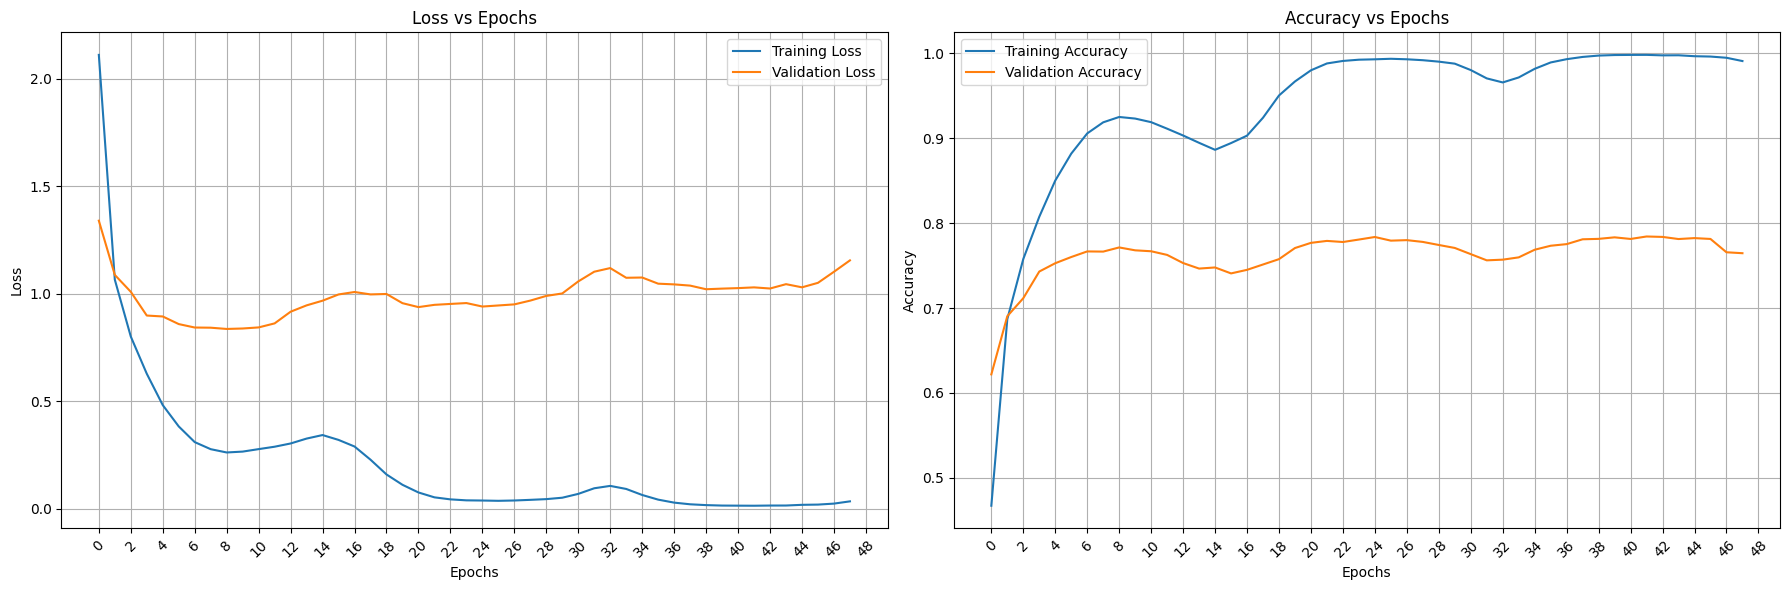

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot losses
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(all_training_losses, label='Training Loss')
plt.plot(all_validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)  # Add grid
plt.xticks(range(0, len(all_training_losses)+1, 2), rotation=45)  # Skip every other tick

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(all_training_accuracies, label='Training Accuracy')
plt.plot(all_validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)  # Add grid
plt.xticks(range(0, len(all_training_accuracies)+1, 2), rotation=45)  # Skip every other tick

plt.tight_layout()
plt.show()

In [8]:
# Evaluate the model on the validation dataset
test_loss, test_accuracy, _ = eval(dataloader=test_dataloader, model=model, criterion=criterion)

print(
    f"🔍 Test Results:\n"
    f"\t📉 Test Loss: {test_loss:.4f}\n"
    f"\t🎯 Test Accuracy: {100 * test_accuracy:.2f}%"
)

Eval progress: 100%|██████████| 79/79 [00:22<00:00,  3.48batch/s]

🔍 Test Results:
	📉 Test Loss: 1.0900
	🎯 Test Accuracy: 77.13%
